In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import viz

from matplotlib import pyplot as plt
from scipy import stats

colors = viz.plotting_style()
lin_colors = colors.values()
plt.style.use('style.mpl')

color_order = ['green', 'blue', 'red', 'purple', 'yellow', 'dark_green', 'dark_blue', 'dark_brown']
lin_colors = [colors[c] for c in color_order]

In [2]:
phi_df = pd.read_csv('../output/Fig2A_variable_lambda.csv')
zcorg_sensitivity_df = pd.read_csv('../output/Fig2B_variable_ZCred.csv')

auto_comp_df = pd.read_csv('../output/Fig2C_autotrophy_samples.csv')
hetero_comp_df = pd.read_csv('../output/Fig2C_heterotrophy_samples.csv')
# Concatentate the two dataframes
# For the main-text figure, focus on one C_red concentration
auto_mask = auto_comp_df['opt.fixed_C_red_mol_gCDW'] == 1e-6
comp_df = pd.concat([auto_comp_df[auto_mask], hetero_comp_df])

auto_comp_C_ext_df = pd.read_csv('../output/Fig2C_autotrophy_ext_C_samples.csv')
auto_comp_C_ext_df

,oxidation_kcat_s,oxidation_m_kDa,reduction_kcat_s,reduction_m_kDa,anabolism_kcat_s,anabolism_m_kDa,cyclic_flow_kcat_s,cyclic_flow_m_kDa,ZCB,ZCorg,...,ATP_homeostasis_gamma,ATP_homeostasis_phi,ATP_homeostasis_flux,analytic_lambda_zo,analytic_lambda_max_zo,S6_lb_zo,S6_ub_zo,ZCorg_lb_zo,ZCorg_ub_zo,model
0,200.0,1725.809598,50.0,211.201275,50.0,1481.521486,50.0,1000.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.000000e+00,-0.686770,-0.686780,0.40002,1.142773,autotrophy_ext_C
1,200.0,859.075163,50.0,629.942886,50.0,1851.664144,50.0,1000.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.000000e+00,-1.724342,-1.724336,0.40002,1.142773,autotrophy_ext_C
2,200.0,2037.163883,50.0,686.251995,50.0,3286.599373,50.0,1000.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.445667e-15,-1.290667,-1.290664,0.40002,1.142773,autotrophy_ext_C
3,200.0,5329.296903,50.0,414.206074,50.0,3182.668145,50.0,1000.0,0.0,0.0,...,0.0,0.0,0.0,0.0,9.155481e-16,-0.477772,-0.477793,0.40002,1.142773,autotrophy_ext_C
4,200.0,773.179709,50.0,837.620232,50.0,220.132752,50.0,1000.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-3.831048e-15,-0.227779,-0.227771,0.40002,1.142773,autotrophy_ext_C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,200.0,200.320738,50.0,1527.014327,50.0,467.087349,50.0,1000.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.000000e+00,-1.865368,-1.865358,0.40002,1.142773,autotrophy_ext_C
96,200.0,1384.475511,50.0,378.697843,50.0,2686.694098,50.0,1000.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.833445e-15,-1.552479,-1.552478,0.40002,1.142773,autotrophy_ext_C
97,200.0,1332.155797,50.0,1183.983133,50.0,1401.584006,50.0,1000.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.000000e+00,-0.841704,-0.841696,0.40002,1.142773,autotrophy_ext_C
98,200.0,1005.633515,50.0,1066.037831,50.0,2442.495623,50.0,1000.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.930865e-15,-1.943060,-1.943053,0.40002,1.142773,autotrophy_ext_C


estimated lambda_max: 2.592
actual lambda_max: 2.287042625886344


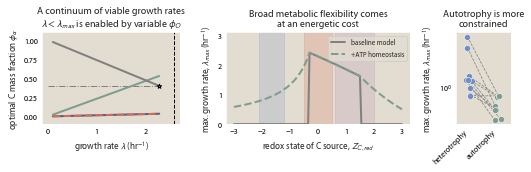

In [3]:
# Notice that phi_O increases as lambda decreases
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(7.24, 2.5),
                        gridspec_kw=dict(width_ratios=[0.75, 1, 0.3]))

# Estimate lambda_max from simple relationships
min_phi_O = 0.4
g_ana = phi_df.anabolism_gamma.values[0]
est_lambda_max = 12*3600*g_ana*(1-min_phi_O)
lambda_max = phi_df.lambda_hr.max()
print('estimated lambda_max:', est_lambda_max)
print('actual lambda_max:', lambda_max)

plt.sca(axs[0])

# Line at min_phi_O
min_phi_O = 0.4
plt.plot([0, lambda_max], [min_phi_O, min_phi_O], 
         color='grey', ls='-.', lw=1)
#plt.text(1.1, min_phi_O+0.03, r'min. $\phi_O$', ha='center', fontsize=9)

x = phi_df['lambda_hr']
# Not plotting homeostasis because it was set to zero
cmap = dict(oxidation=colors['dark_blue'],
            reduction=colors['red'],
            anabolism=colors['dark_green'],
            other='grey')
processes = 'oxidation,reduction,anabolism'.split(',')
process_labels = dict(
    oxidation=r'$\phi_{ox}$',
    reduction=r'$\phi_{red}$',
    anabolism=r'$\phi_{ana}$',
    other=r'$\phi_O$')
phi_cols = ['{}_phi'.format(p) for p in processes] + ['phi_O']
for i, col in enumerate(phi_cols):
    label = processes[i] if i < len(processes) else r'other'
    legend_label = process_labels[label]
    c = cmap[label]
    ls = '--' if label == 'reduction' else '-'
    plt.plot(x, phi_df[col], label=legend_label, color=c, ls=ls)
plt.scatter([lambda_max], [min_phi_O], color=colors['purple'], edgecolor='k', marker='*', zorder=10, s=20)

plt.axvline(est_lambda_max, color='k', ls='--', lw=1) 
#plt.text(est_lambda_max-0.02, 0.3, r'$\lambda_{max} \approx \gamma_{ana}(1-\phi_O)$', ha='right', va='center', rotation=90, fontsize=9)
plt.xlabel(r'growth rate $\lambda$ (hr$^{-1}$)')
plt.ylabel(r'optimal C mass fraction $\phi_\alpha$')   
#plt.legend(loc=1)
plt.ylim(-0.1, 1.1)

plt.sca(axs[1])
phi_H_included = zcorg_sensitivity_df[
    zcorg_sensitivity_df['opt.max_phi_H_set'] == False]
no_phi_H = zcorg_sensitivity_df[
    zcorg_sensitivity_df['opt.max_phi_H_set'] == True]

plt.plot(no_phi_H.ZCorg, no_phi_H.lambda_hr, color='grey',
         label=r'baseline model'.format(min_phi_O))
plt.plot(phi_H_included.ZCorg, phi_H_included.lambda_hr,
         color=colors['dark_green'], ls='--',
         label=r'+ATP homeostasis', zorder=10)

plt.axvspan(-2.1, -1.2, color=colors['blue'], alpha=0.2, zorder=-10)
plt.axvspan(-0.5, 0.5, color=colors['red'], alpha=0.2, zorder=-10)
plt.axvspan(0.6, 2, color=colors['purple'], alpha=0.2, zorder=-10)

plt.legend(loc=1)
plt.ylim(0, 3.1)
plt.xlabel('redox state of C source, $Z_{C,red}$')
plt.ylabel(r'max. growth rate, $\lambda_{max}$ (hr$^{-1}$)')

plt.sca(axs[2])
plt.yscale('log')
# Plot the pairs of growth rates calculated with the same sampled params
# Note: we are neglecting max growth rates that are very low for heterotrophy
# since this is implausible in the first place.
mask = (hetero_comp_df.lambda_hr > 0.05)
idxs = hetero_comp_df[mask].index[:10]
auto_examples = auto_comp_df.iloc[idxs].copy()
np.random.seed(23)
auto_examples['x_pos'] = 1 + np.random.normal(0, 0.07, size=10)
hetero_examples = hetero_comp_df.iloc[idxs].copy()
hetero_examples['x_pos'] = 0 + np.random.normal(0, 0.07, size=10)

sns.scatterplot(data=auto_examples, x='x_pos', y='lambda_hr', color=colors['dark_green'])
sns.scatterplot(data=hetero_examples, x='x_pos', y='lambda_hr', color=colors['blue'])
for i in range(10):
    auto_ex = auto_examples.iloc[i]
    hetero_ex = hetero_examples.iloc[i]
    plt.plot([hetero_ex.x_pos, auto_ex.x_pos], [hetero_ex.lambda_hr, auto_ex.lambda_hr],
             color='grey', lw=0.75, zorder=0, ls='--')

plt.xticks([0, 1], ['heterotrophy', 'autotrophy'], ha='right', rotation=45)
plt.ylabel(r'max. growth rate, $\lambda_{max}$ (hr$^{-1}$)')
plt.xlim(-0.5, 1.5)
plt.xlabel('')

titles = [
    'A continuum of viable growth rates\n $\lambda < \lambda_{max}$ is enabled by variable $\phi_O$',
    'Broad metabolic flexibility comes\nat an energetic cost',
    'Autotrophy is more\nconstrained'
]
for title, label, ax in zip(titles, 'ABC', axs):
    #ax.text(0.03, 0.97, label, transform=ax.transAxes, fontsize=10, fontweight='bold', va='top')
    ax.set_title(title)
    
plt.tight_layout()
plt.savefig('../output/Fig2.png', facecolor='white', bbox_inches='tight', dpi=300)
plt.show()

1e-12
1e-06
0.1


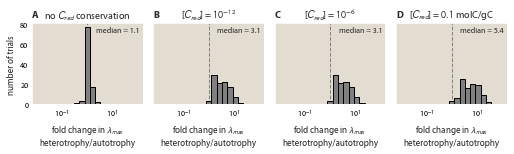

In [4]:
fig, axs = plt.subplots(figsize=(7.24, 2.25), ncols=4, sharey=True)

plt.sca(axs[0])
data = np.vstack([auto_comp_C_ext_df.lambda_hr.values, hetero_comp_df.lambda_hr.values]).T
auto_comp_lambdas = pd.DataFrame(data, columns='auto_lambda_hr,hetero_lambda_hr'.split(','))
auto_comp_lambdas['fc'] = auto_comp_lambdas.hetero_lambda_hr / auto_comp_lambdas.auto_lambda_hr
plt.ylabel('number of trials')
median_fc = auto_comp_lambdas.fc.median()
plt.text(0.97, 0.97, 'median = {0:.1f}'.format(median_fc),
         ha='right', va='top', fontsize=8, transform=axs[0].transAxes)


# Plot the distribution of the fold change in growth rate
bins = np.logspace(-2, 2, 20)
plt.xscale('log')
plt.hist(auto_comp_lambdas.fc, bins=bins, color='grey', edgecolor='k')

# extract the pairs of growth rates calculated with the same sampled params
for i, (fixed_C_red, gdf) in enumerate(auto_comp_df.groupby('opt.fixed_C_red_mol_gCDW')):
   data = np.vstack([gdf.lambda_hr.values, hetero_comp_df.lambda_hr.values]).T
   auto_comp_lambdas = pd.DataFrame(data, columns='auto_lambda_hr,hetero_lambda_hr'.split(','))
   auto_comp_lambdas['fc'] = auto_comp_lambdas.hetero_lambda_hr / auto_comp_lambdas.auto_lambda_hr

   plt.sca(axs[i+1])
   print(fixed_C_red)

   # Plot the distribution of the fold change in growth rate
   plt.xscale('log')
   plt.hist(auto_comp_lambdas.fc, bins=bins, color='grey', edgecolor='k')
   median_fc = auto_comp_lambdas.fc.median()
   plt.text(0.97, 0.97, 'median = {0:.1f}'.format(median_fc),
            ha='right', va='top', fontsize=8, transform=axs[i+1].transAxes)


plt.title('no $C_{red}$ conservation')
titles = ['no $C_{red}$ conservation',
          '[$C_{red}$] = $10^{-12}$',
          '[$C_{red}$] = $10^{-6}$',
          '[$C_{red}$] = $0.1$ molC/gC',
          ]
panels = 'ABCD'
for i, ax in enumerate(axs):
   plt.sca(ax)
   plt.xlabel('fold change in $\lambda_{max}$\nheterotrophy/autotrophy')
   plt.title(titles[i])
   plt.title(panels[i], loc='left', fontweight='bold')
   plt.axvline(1, ls='--', color='grey', lw=1, zorder=-10)

plt.tight_layout()
plt.savefig('../output/Fig2S2_autotrophy_constraint.png', facecolor='white', dpi=300)
plt.show()


In [5]:
auto_comp_C_ext_df['lambda_hr'] 
hetero_comp_df['lambda_hr']

0     1.609274
1     1.328592
2     0.747368
3     0.726948
4     7.913879
        ...   
95    4.451700
96    0.924312
97    1.651653
98    1.004412
99    1.253590
Name: lambda_hr, Length: 100, dtype: float64

In [6]:
auto_var_zcred_df = pd.read_csv('../output/FigSX_autotrophy_ZCred.csv')
auto_var_zcred_df['lambda_hr,ZCorg'.split(',')]

,lambda_hr,ZCorg
0,0.000000,-2.00
1,0.000000,-1.95
2,0.000000,-1.90
3,0.000000,-1.85
4,0.000000,-1.80
...,...,...
76,0.068031,1.80
77,0.067500,1.85
78,0.066977,1.90
79,0.066462,1.95


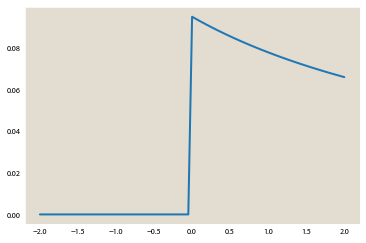

In [7]:
# Notice that organics need to be more oxidized than biomass
# otherwise you get e- from anabolism and have no where to 
# put them but into the synthesis of more organics. 
plt.plot(auto_var_zcred_df.ZCorg, auto_var_zcred_df.lambda_hr)

In [8]:

var_phi_O_df = pd.read_csv('../output/Fig2S1_variable_phi_O.csv')
var_phi_red_df = pd.read_csv('../output/Fig2S1_variable_phi_red.csv')
var_g_ana_df = pd.read_csv('../output/Fig2S1_variable_g_ana.csv')
var_g_red_df = pd.read_csv('../output/Fig2S1_variable_g_red.csv')


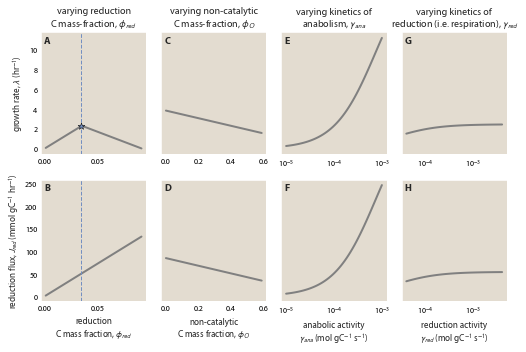

In [9]:
# Supplementary figure focusing on respiratory rates
# TODO: add variable stoichiometry, e.g. S4, to these panels
# TODO: calculate CUE and plot that as well
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(7.24, 5), sharey='row')
flat_axs = axs.flatten(order='F')

# Left panel: varying phi_red
# Model can use ATP homeostasis to maximize growth
plt.sca(axs[0,0])
max_idx = var_phi_red_df.lambda_hr.idxmax()
plt.plot(var_phi_red_df.reduction_phi, var_phi_red_df.lambda_hr, color='grey')
plt.scatter(var_phi_red_df.reduction_phi[max_idx], var_phi_red_df.lambda_hr[max_idx],
            color=colors['blue'], marker='*', zorder=10, s=50, edgecolor='k', lw=0.5)
plt.axvline(var_phi_red_df.reduction_phi[max_idx], color=colors['blue'], ls='--', lw=1)
plt.ylabel(r'growth rate, $\lambda$ (hr$^{-1}$)')
plt.title('varying reduction\nC mass-fraction, $\phi_{red}$')
plt.sca(axs[1,0])
plt.plot(var_phi_red_df.reduction_phi, var_phi_red_df.reduction_flux*3.6e6,
         color='grey')
plt.axvline(var_phi_red_df.reduction_phi[max_idx], color=colors['blue'], ls='--', lw=1)
plt.ylabel(r'reduction flux, $J_{red}$ (mmol gC$^{-1}$ hr$^{-1}$)')
plt.xlabel('reduction\nC mass fraction, $\phi_{red}$')

# Left panel: varying phi_O
# Model can use ATP homeostasis to maximize growth
plt.sca(axs[0,1])
plt.plot(var_phi_O_df.phi_O, var_phi_O_df.lambda_hr, color='grey', label=r'$\phi_O \geq$ {0:.1f}'.format(min_phi_O))
plt.title('varying non-catalytic\nC mass-fraction, $\phi_O$')
plt.sca(axs[1,1])
plt.plot(var_phi_O_df.phi_O, var_phi_O_df.reduction_flux*3.6e6, color='grey', label=r'$\phi_O \geq$ {0:.1f}'.format(min_phi_O))
plt.xlabel('non-catalytic\nC mass fraction, $\phi_O$')

# Middle panels: varying anabolism gamma
# TODO: narrow range here so growth rates don't balloon as much
mask = var_g_ana_df['opt.max_phi_H_set'] == False
masked = var_g_ana_df[mask]

plt.sca(axs[0,2])
plt.xscale('log')
plt.plot(masked.anabolism_gamma, masked.lambda_hr, color='grey', label=r'$\phi_O \geq$ {0:.1f}'.format(min_phi_O))
plt.title('varying kinetics of\nanabolism, $\gamma_{ana}$')
plt.sca(axs[1,2])
plt.xscale('log')
plt.plot(masked.anabolism_gamma, masked.reduction_flux*3.6e6, color='grey', label=r'$\phi_O \geq$ {0:.1f}'.format(min_phi_O))
plt.xlabel('anabolic activity\n$\gamma_{ana}$ (mol gC$^{-1}$ s$^{-1}$)')

# Right panels: varying anabolism gamma
mask = var_g_red_df['opt.max_phi_H_set'] == False
masked = var_g_red_df[mask]

plt.sca(axs[0, 3])
plt.xscale('log')
plt.plot(masked.reduction_gamma, masked.lambda_hr, color='grey', label=r'$\phi_O \geq$ {0:.1f}'.format(min_phi_O))
plt.title('varying kinetics of\n reduction (i.e. respiration), $\gamma_{red}$')
plt.sca(axs[1, 3])
plt.xscale('log')
plt.plot(masked.reduction_gamma, masked.reduction_flux*3.6e6, color='grey', label=r'$\phi_O \geq$ {0:.1f}'.format(min_phi_O))
plt.xlabel('reduction activity\n$\gamma_{red}$ (mol gC$^{-1}$ s$^{-1}$)')

for label, ax in zip("ABCDEFGH", flat_axs):
    ax.text(0.03, 0.97, label, transform=ax.transAxes, fontsize=10, fontweight='bold', va='top')

plt.tight_layout()
plt.savefig('../output/Fig2S1_max_Jred.png', facecolor='white', bbox_inches='tight', dpi=300)